# Library Imports

In [26]:
import numpy as np
import cv2
from sklearn.preprocessing import StandardScaler
from PIL import Image
import os
import random
from datetime import datetime

# Image Matrix Construction

In [27]:
file_dict = {} # dictionary to hold path to each image (for reduced space & faster access time)

def create_vec(location, count_of_same_celebrity=40):
    '''
    Create a random vectorized array with 'n' number of images of each celebrity

    location: location of the master folder
    count_of_same_celebrity: number of random images taken of the same celebrity
    '''
    # Create an empty list to store arrays
    img_arrays = []
    global file_dict

    idx = 0

    for celeb in os.listdir(location):
        celeb_path = os.path.join(location, celeb)
        if not os.path.isdir(celeb_path):
            continue  # Skip if the item in the directory is not a folder

        files = [f for f in os.listdir(celeb_path) if os.path.isfile(os.path.join(celeb_path, f))]

        # Use min() to avoid going beyond the available indices
        selected_files = random.sample(files, min(len(files), count_of_same_celebrity))

        for selected_file in selected_files:
            face_path = os.path.join(celeb_path, selected_file)
            file_dict[idx] = face_path
            idx+=1

            # Open and resize the face image
            face_image = Image.open(face_path).convert("L")  # Convert to grayscale
            resized_face_image = face_image.resize((20, 20))
            img_array = np.array(resized_face_image).flatten()
            img_arrays.append(img_array)

    # Convert the list of arrays into a NumPy array
    img_matrix = np.transpose(img_arrays)

    return img_matrix


A = create_vec('Cropped Celebrity Faces Dataset')
n = A.shape[0]
m = A.shape[1]
mean = np.mean(A, axis=1, keepdims=True)
O = A - mean

# Key Generation

In [28]:
print('KeyGen')
start_time = datetime.now()
from scipy.sparse import rand
s = np.random.randint(1,50)

u1 = rand(n + 2 * s, 1, density=1 / np.sqrt(n + 2 * s));
u2 = rand(m + 2 * s, 1, density=1 / np.sqrt(m + 2 * s));
u1=u1.toarray();
u2=u2.toarray();
B = np.random.rand(s, s)
B1 = np.random.rand(s, s)
u1 = u1 / np.linalg.norm(u1)
u2 = u2 / np.linalg.norm(u2)
P = np.identity(n + 2 * s) - 2 * (u1 @ u1.T)
Q = np.identity(m + 2 * s) - 2 * (u2 @ u2.T)
alpha = np.random.rand()
beta = np.random.rand()
gamma = np.random.rand()
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


KeyGen
Duration: 0:00:00.009804


# Encryption

In [29]:
print('Problem Generation')
start_time = datetime.now()

# Forming Block Matrix
X = np.block([[B, np.zeros((s, m)), beta * B1],
              [np.zeros((n, s)),  gamma*O, np.zeros((n, s))],
              [alpha * B, np.zeros((s, m)), B1]])

#Multiplying Orthogonal Matrices
T = P @ X @ Q
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Problem Generation
Duration: 0:00:00.013002


# Outsourcing to Cloud

In [30]:
# Variables to Server
# T, the encrypted matrix
np.savetxt('T.txt', T, delimiter=',')

# Results from the cloud

In [31]:
# Once we get them from server, we run the following code
U_svd = np.loadtxt("U_svd.txt", delimiter=',')
S_svd = np.loadtxt("S_svd.txt", delimiter=',')
V_svd = np.loadtxt("V_svd.txt", delimiter=',')

# Verification

In [32]:
l=int(input('No. of trials'))
for i in range(l):
    e3 = np.random.choice([0, 1], size=(U_svd.shape[0]))
    err3 = np.linalg.norm(U_svd.T @ (U_svd @ e3) - e3)
    
    if err3 >= 1e-4:
        print("Verification failed")
        break



for i in range(l):
    e2 = np.random.choice([0, 1], size=(V_svd.shape[0]))
    err2 = np.linalg.norm(V_svd.T @ (V_svd @ e2) - e2)
    
    if err2 >= 1e-4:
        print("Verification failed")
        break
    
    
    e1 = np.random.choice([0, 1], size=(V_svd.shape[0]))
    err1 = np.linalg.norm(U_svd @ (S_svd @ (V_svd.T @ e1)) - T @ e1)
    
    if err1 >= 1e-4:
        print("Verification failed")
        break
else:
    print("Verification successful for all trials")

No. of trials80
Verification successful for all trials


# Solving

In [33]:
print("Solve")
start_time = datetime.now()
U1 = P.T @ U_svd
V1 = Q @ V_svd
S = S_svd
#U1 @ S @ V1.T - X

U2=U1[s:s+n,:]
V2=V1[s:s+m,:]

# Remove columns and corresponding rows with small singular values
tolerance = 1e-4  # Set your desired tolerance

# Find columns with singular values greater than the tolerance
valid_columns = np.max(np.abs(S), axis=0) > tolerance

# Apply the column filtering to S, U2, and V2
S = S[:, valid_columns]
#U2 = U2[:, valid_columns]
V2 = V2[:, valid_columns]

# Find rows with singular values greater than the tolerance
valid_rows = np.max(np.abs(S), axis=1) > tolerance

# Apply the row filtering to S, U2, and V2
S = S[valid_rows, :]
U2 = U2[:,valid_rows]
#V2 = V2[valid_rows, :]


tol = 1e-4
mask = np.all(np.abs(U2) <= tol, axis=0)
U3 = U2[:, ~mask]
S1 = S[~mask,:]


mask1 = np.all(np.abs(V2) <= tol, axis=0)
V3 = V2[:, ~mask1]
S2 = S1[:,~mask1]
S2 = 1/gamma * S2
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Solve
Duration: 0:00:00.024624


# Sorting Eigenvalues and generating eigenfaces

In [37]:
S_list = np.diag(S2)
sorted_indices = np.argsort(S_list)[::-1]
U_sorted = U3[:, sorted_indices]

# Number of eigenfaces
num_components = 100
selected_U = U_sorted[:, :num_components]
selected_U.shape
# Project data onto selected eigenvectors (eigenfaces)
W = selected_U.T @ O

# Testing Image

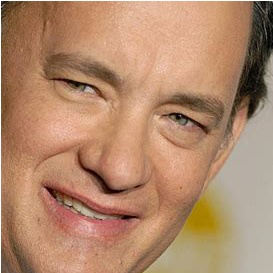

In [38]:
def preprocess_test_image(file_path, target_size=(20, 20)):
    img = Image.open(file_path).convert('L')  # Convert image to grayscale
    img_resized = img.resize(target_size, Image.LANCZOS)  # Resize image to a uniform size
    img_array = np.array(img_resized).flatten()  # Flatten the resized image to a single column vector
    return img_array

# Path to your test image file (replace with the actual path to your test image)
test_image_path = 'Test/Tom Hanks/008_74cd0628.jpg'  # Replace with your test image file path

from IPython.display import display
import matplotlib.pyplot as plt
img = Image.open(test_image_path)
display(img)

In [39]:
# Load and preprocess the test image into a column vector
x = preprocess_test_image(test_image_path)

x_reshaped = x.reshape(-1,1)
x_reshaped.shape

# Normalizing
x_norm = x_reshaped - mean
# Transforming
x_trans = selected_U.T @ x_norm

In [40]:
d = np.linalg.norm(x_trans - W, axis=0)
d_min = np.min(d)
d_index = np.argmin(d)

In [41]:
from IPython.display import display

def display_original(n):
  '''
  n: a number less than A.shape[1] and the index of the image to be displayed
  '''
  global file_dict
  display(Image.open(file_dict[n]))

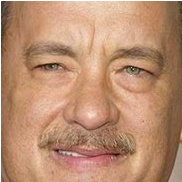

In [42]:
display_original(d_index)